In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import utils.add_features as af
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tcn import TCN, tcn_full_summary
from copy import deepcopy 

2024-03-10 16:38:48.948051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 16:38:48.948086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 16:38:48.949189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 16:38:48.955817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 16:38:49.657685: W tensorflow/compiler/tf2

In [2]:
SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'
MODEL_PATH           = './models/test4/best_model.keras'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 864 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 64 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000


In [3]:
DATA_PATHS = [
              './datasets/ambient_measurements/2022/temp.csv',
             ]

datasets = [pd.read_csv(path, index_col=0, parse_dates=True) for path in DATA_PATHS]
datasets = [af.interpolate_and_resample(df, freq=RESAMPLE_FREQ) for df in datasets]

In [4]:
full_dataset = af.encode_date(af.join_data(datasets))
full_dataset = af.add_rolling_features(full_dataset, windows=['10min',], variables=['temp_level'], features=['mean', 'std', 'min', 'max']).bfill()
full_dataset.shape

(9709, 9)

In [5]:
full_dataset.head()

,temp_level,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,temp_level_10min_mean,temp_level_10min_std,temp_level_10min_min,temp_level_10min_max
time,,,,,,,,,
2022-05-09 21:20:00,21.15,-12.470015,20.506066,290.606745,-220.845465,21.150,0.014142,21.15,21.15
2022-05-09 21:25:00,21.13,-12.470015,20.506066,290.606745,-220.845465,21.140,0.014142,21.13,21.15
2022-05-09 21:30:00,21.10,-12.470015,20.506066,290.606745,-220.845465,21.115,0.021213,21.10,21.13
2022-05-09 21:35:00,21.03,-12.470015,20.506066,290.606745,-220.845465,21.065,0.049497,21.03,21.10
2022-05-09 21:40:00,20.97,-12.470015,20.506066,290.606745,-220.845465,21.000,0.042426,20.97,21.03


In [6]:
NFEATURES = 9

# split the data and generate the windowed datasets

In [7]:
# Split the data into training and testing sets
train = deepcopy(full_dataset[:SPLIT_DATE])
test = deepcopy(full_dataset[SPLIT_DATE:])

In [8]:
def windowed_dataset(fulldata: pd.DataFrame,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      fulldata (pd.DataFrame) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Convert the series to a numpy array
    series = fulldata.to_numpy()

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:, 0]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [9]:
train_dataset = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD, shuffle=False)

# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')
  #print(f'first element: {windows[1]}')

2024-03-10 16:38:50.577570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 16:38:50.598097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 16:38:50.598299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (64, 864, 9)
shape of second element: (64, 36)


# first model trial 

In [10]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, NFEATURES]),
    TCN(
        nb_filters=256,
        kernel_size=2,
        dilations=[1, 2, 4, 8, 16, 32],
        activation='tanh',
        use_skip_connections=True,
        return_sequences=False
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 256)               1452032   
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 36)                9252      
                                                                 
Total params: 1461284 (5.57 MB)
Trainable params: 1461284 (5.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
loss = tf.losses.Huber() #tf.losses.MeanSquaredError()
model1.compile(loss = loss,
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')
# Callback to save the best model
best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,    # The path where to save the model
    monitor='val_loss',          # The metric to monitor
    verbose=1,                   # Verbosity mode
    save_best_only=True,         # Save only the best model
    mode='min'                   # Minimize the monitored metric (val_loss)
)

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping, best_model_checkpoint])

Epoch 1/100


2024-03-10 16:38:54.347102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 16:38:54.427667: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 16:38:57.934574: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 16:38:58.769730: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efda430a110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 16:38:58.769766: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-03-10 16:38:58.779195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710106738.886323  125419 device_compil

     71/Unknown - 61s 628ms/step - loss: 2.1556 - mae: 2.5643 - mse: 26.9436

2024-03-10 16:39:57.370266: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 16:39:57.911441: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


     72/Unknown - 73s 788ms/step - loss: 2.1324 - mae: 2.5411 - mse: 26.5940

2024-03-10 16:40:20.116708: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 16:40:20.279894: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 16:40:20.472701: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 16:40:20.639024: W external/local_tsl/tsl/framework/bfc_


Epoch 1: val_loss improved from inf to 1.02865, saving model to ./models/test4/best_model.keras
72/72 [==============================] - 89s 1s/step - loss: 2.1324 - mae: 2.5411 - mse: 26.5940 - val_loss: 1.0286 - val_mae: 1.4858 - val_mse: 2.8769
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.3159 - mae: 0.6568 - mse: 0.6993
Epoch 2: val_loss improved from 1.02865 to 0.92769, saving model to ./models/test4/best_model.keras
72/72 [==============================] - 59s 817ms/step - loss: 0.3159 - mae: 0.6568 - mse: 0.6993 - val_loss: 0.9277 - val_mae: 1.3780 - val_mse: 2.5262
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.2023 - mae: 0.4994 - mse: 0.4380
Epoch 3: val_loss improved from 0.92769 to 0.68694, saving model to ./models/test4/best_model.keras
72/72 [==============================] - 60s 834ms/step - loss: 0.2023 - mae: 0.4994 - mse: 0.4380 - val_loss: 0.6869 - val_mae: 1.1168 - val_mse: 1.7147
Epoch 4/100
72/72 [================

In [13]:
custom_objects = {'TCN': TCN}

# Load the best saved model
best_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

# Evaluate the best model on the test dataset
test_loss, test_mae, test_mse = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}')

52/52 [==============================] - 13s 241ms/step - loss: 0.3852 - mae: 0.7592 - mse: 0.8464
Test Loss: 0.38523876667022705, Test MAE: 0.759239137172699, Test MSE: 0.8463730216026306


2024-03-10 17:02:39.145242: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14070589464348350723
2024-03-10 17:02:39.145301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9772216332333157028


In [14]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [15]:
def plot_random_predictions(model_baseline,
                            test_dataset,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    print(f'Expected shape: {expected.shape}')
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        xrange = np.arange(len(expected[sample]))
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        subplots[i].plot(xrange, expected[sample], label='Expected', color='blue')
        subplots[i].plot(xrange, list(baseline_preds[sample]), label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()

52/52 [==============================] - 13s 242ms/step
Expected shape: (3306, 36)


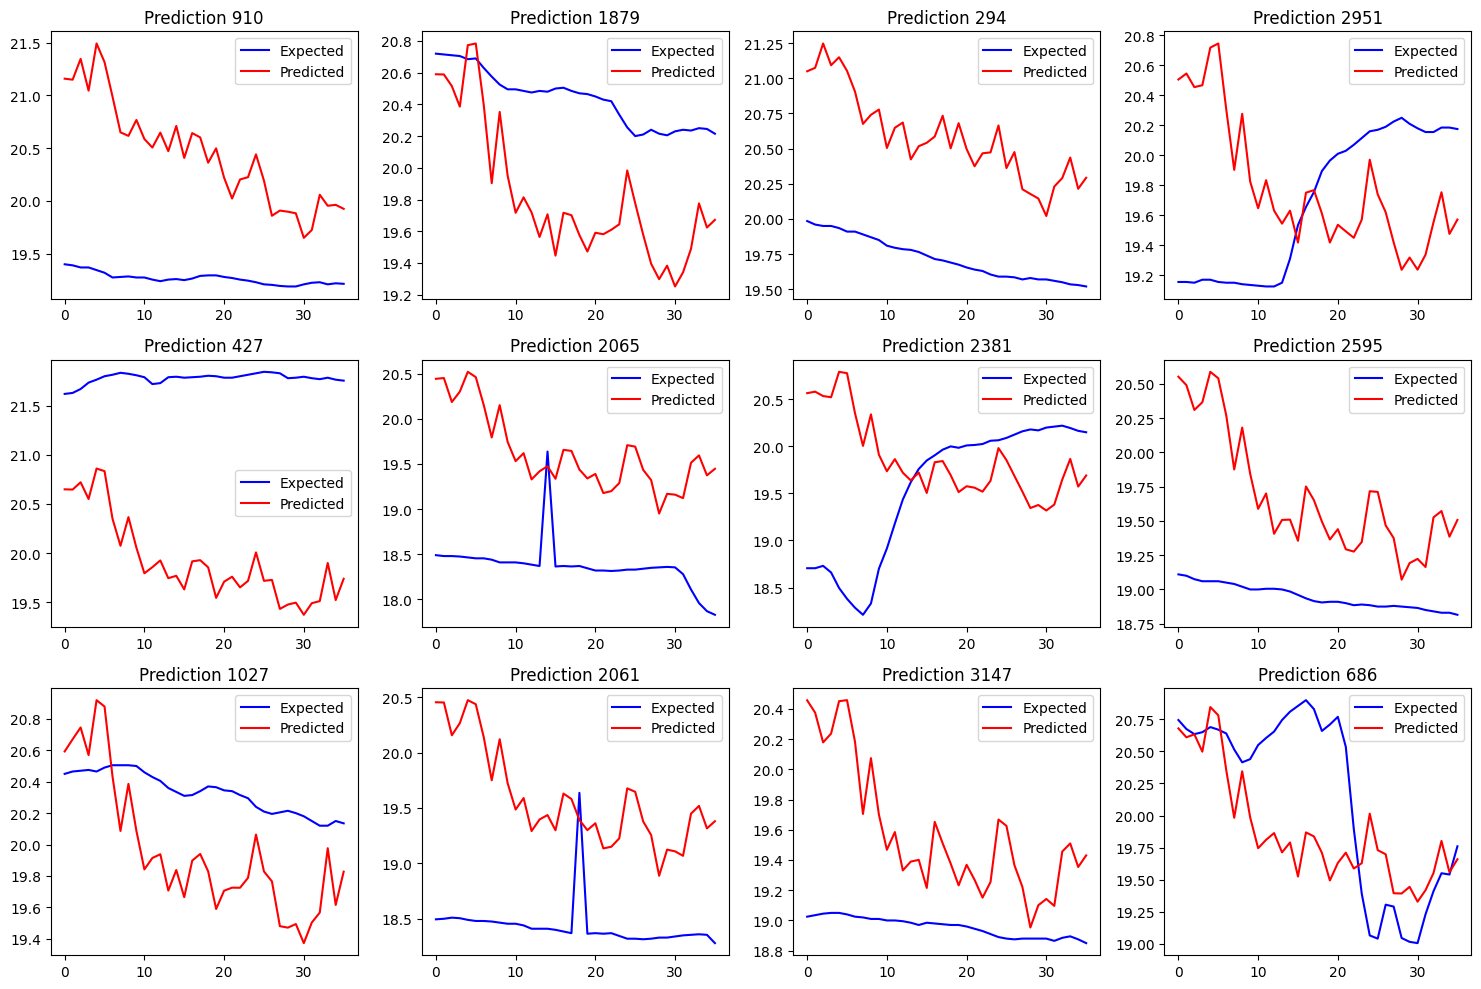

In [16]:
plot_random_predictions(model1, test_dataset, N=12, COLS=4)